In [26]:
# 1. Import bibliotek

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import random

Train set size: 89996
Validation set size: 10004
Test set size: 7180


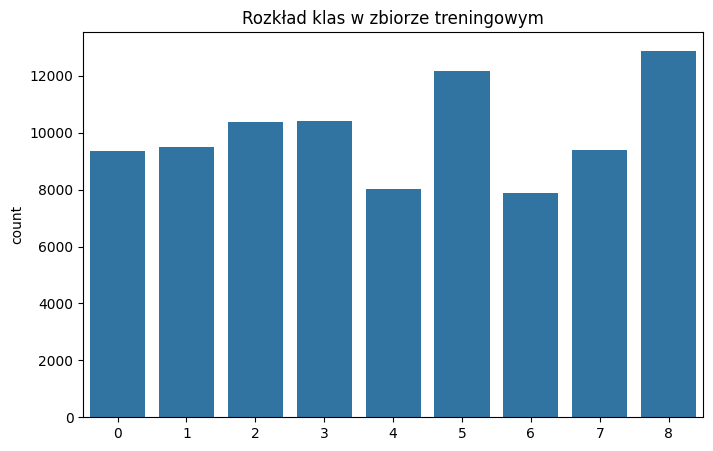

In [27]:
# 2. Analiza danych

path_to_npz = 'data/pathmnist_64.npz'  # <-- poprawna ścieżka do danych

data = np.load(path_to_npz)

train_images = data['train_images'].astype('float32') / 255.0
train_labels = data['train_labels'].flatten()
val_images = data['val_images'].astype('float32') / 255.0
val_labels = data['val_labels'].flatten()
test_images = data['test_images'].astype('float32') / 255.0
test_labels = data['test_labels'].flatten()

print(f"Train set size: {train_images.shape[0]}")
print(f"Validation set size: {val_images.shape[0]}")
print(f"Test set size: {test_images.shape[0]}")

# Rozkład etykiet
plt.figure(figsize=(8,5))
sns.countplot(x=train_labels)
plt.title('Rozkład klas w zbiorze treningowym')
plt.show()

In [28]:
# 3. Przygotowanie danych - Tensor + Augmentacja

# Transformacje augmentacyjne
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
])

class PathMNISTDataset(Dataset):
    def __init__(self, images, labels, augment=False):
        self.images = images
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = torch.tensor(image).permute(2, 0, 1)
        if self.augment:
            image = augmentations(image)
        return image.float(), label

batch_size = 64

train_dataset = PathMNISTDataset(train_images, train_labels, augment=True)
val_dataset = PathMNISTDataset(val_images, val_labels, augment=False)
test_dataset = PathMNISTDataset(test_images, test_labels, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# 4. Definicja modelu

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # dla obrazkow 64x64
        self.fc2 = nn.Linear(128, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [30]:
# 5. Trening modelu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Walidacja
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/10 - Train Loss: 0.9258 - Val Loss: 0.6477
Epoch 2/10 - Train Loss: 0.6265 - Val Loss: 0.5848
Epoch 3/10 - Train Loss: 0.5258 - Val Loss: 0.4264
Epoch 4/10 - Train Loss: 0.4538 - Val Loss: 0.3160
Epoch 5/10 - Train Loss: 0.3926 - Val Loss: 0.2923
Epoch 6/10 - Train Loss: 0.3584 - Val Loss: 0.2872
Epoch 7/10 - Train Loss: 0.3281 - Val Loss: 0.2489
Epoch 8/10 - Train Loss: 0.3104 - Val Loss: 0.2657
Epoch 9/10 - Train Loss: 0.2882 - Val Loss: 0.2504
Epoch 10/10 - Train Loss: 0.2742 - Val Loss: 0.3322


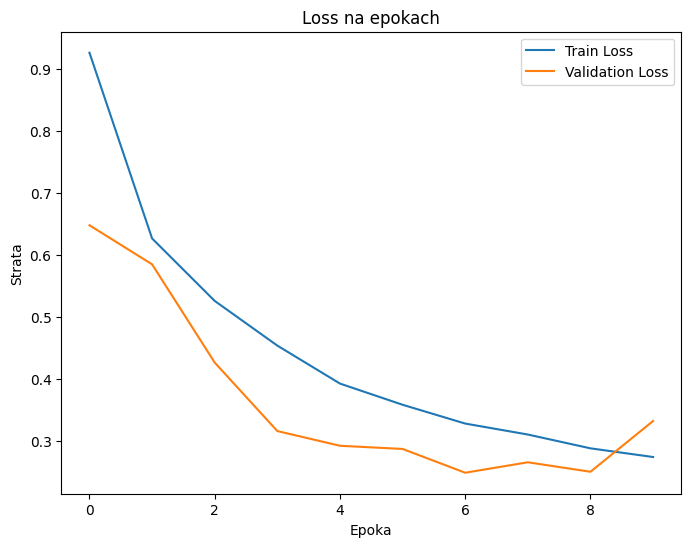

In [31]:
# 6. Wykres strat

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss na epokach')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.show()

Test Accuracy: 0.8422


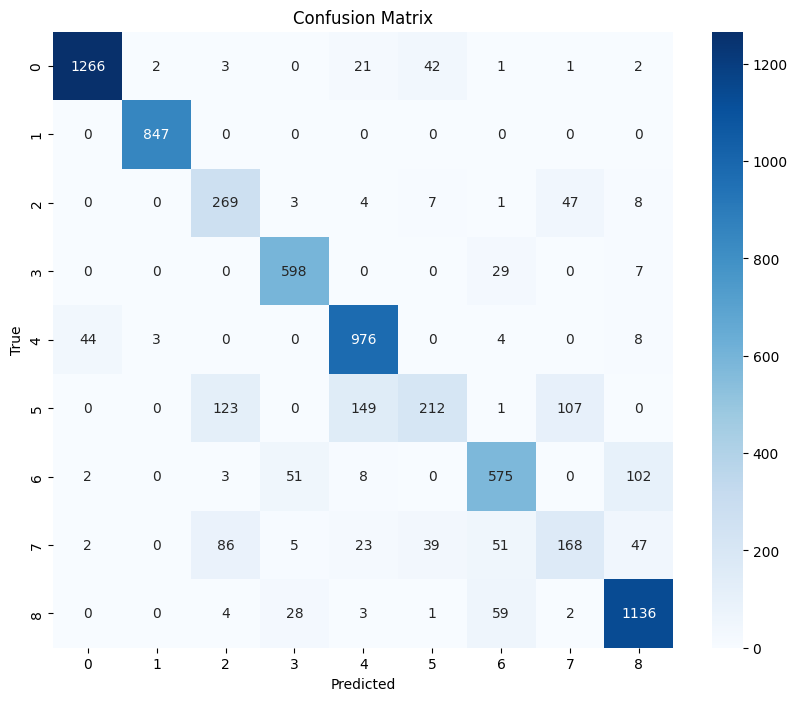

In [32]:
# 7. Ewaluacja na zbiorze testowym

model.eval()
all_preds = []
all_labels_eval = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels_eval.extend(labels.numpy())

acc = accuracy_score(all_labels_eval, all_preds)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels_eval, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()